# Goals
The goal of this notebook is to get an idea of the range of parameters that result in acceptable image analysis. Ideally, the result will be a set of parameters that work for all the test images. More realistically, the result will be a range of parameters that work for the test images and some sort of criteria to distinguish which parameters work for which images.

# Approach
1. Choose 5 datasets that "look good" in term of descriptive statistics, eye test, and notes in metadata
2. Manually tune analysis for these datasets
    1. Look at a max projection of the current trial, select the slices that contain the data of interest, and make sure metadata notes don't have anything disqualifying.
    2. Twiddle with parameters until we get some that work pretty well for one time point
    3. Run these parameters on the all the time points of the trial and see if any parameters changes need to be made.
3. Compare tuned values and look for correlation with descriptive statistics

# Open questions
#### How can I display failure modes?
- Show max projection of each stack with particles indicated?
- Find stack that has particles missing?
- Show max projection from the side for z-location?
- Show max projection of selected slices, slices below selection, and selection above selection

#### How do I save the results?
- How do I indicate if a given trial is good enough to use for subsequent analysis?
- Save parameters from analysis
    - Currently saved in yaml file, as well as yaml history that records each analysis run
- Save metadata
- Which output do I save?
- How do I load things like parameters to rerun analysis?
- How do I indicate which trials have been analyzed?

#### How do I translate this to a more permanent analysis suite?
- Move to another jupyter notebook?
- Move to spyder?
- Which output do I save?
- How do I load things like parameters to rerun analysis?
- How do I indicate which trials have been analyzed?
- Use object-oriented program?

# To-do list
- Clean up diagnostic plots and make them display failure modes 
- Implement indicator of good/bad trials
- Implement list of things I learned from bad trials
- <s>Generalize code by creating higher-level functions for each of the three steps </s>
    - <s>Save/Load analysis parameters when running analysis </s>
    - <s>Append to list of analysis parameters as well as save the current parameters</s>
- Check out %%cache magic to avoid re-running analyses
- Update function and varibale names to make them more descriptive
- Save bottom and top slice to YAML file

### Import packages

In [1]:
import sys
import os
import glob
import time

import gspread
from oauth2client.service_account import ServiceAccountCredentials

import numpy as np
import pandas as pd
from nd2reader import ND2Reader 
from scipy import ndimage as ndi
from scipy import stats
import pims
from PIL import Image

import trackpy as tp
import warnings
warnings.filterwarnings("ignore", 
    message="Using a non-tuple sequence for multidimensional indexing is deprecated")


import yaml
class PrettySafeLoader(yaml.SafeLoader):
    def construct_python_tuple(self, node):
        return tuple(self.construct_sequence(node))
PrettySafeLoader.add_constructor(
    u'tag:yaml.org,2002:python/tuple',
    PrettySafeLoader.construct_python_tuple)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
warnings.filterwarnings("ignore", module="matplotlib")

from ipywidgets import interact, interact_manual
import ipywidgets as ipw
import asyncio
%gui asyncio

In [2]:
%load_ext ipycache

/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


### Functions for importing images and metadata

In [3]:
def loadImages(expID):
    parentDir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
    filename = glob.glob(parentDir + '*/' + expID + '*')
    filename = filename[0]
    
    warnings.filterwarnings("ignore", message="Reported average frame interval")
    
    images = pims.open(filename)
    images.bundle_axes = ['z', 'y', 'x']
#     meta = images.metadata
#     print(meta)
#     numSlices = meta['total_images_per_channel']
    
    imageArray = np.asarray(images)
    imageArray = imageArray.squeeze()
    # print(imageArray.shape)
    return imageArray

In [4]:
def getMetadata(experimentID):
    parentDir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
    filename = glob.glob(parentDir + '*/' + experimentID + '*')
    filename = filename[0]
    
    # Access google drive spreadsheet
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('SenseOfTouchResearch-e5927f56c4d0.json', scope)
    c = gspread.authorize(credentials)
    metadataSpread = c.open_by_key('1LsTdPBOW79XSkk5DJv2ckiVTvpofAOOd_dJL4cgtxBQ')
    metadataFrame = pd.DataFrame(metadataSpread.sheet1.get_all_records())
    gdriveMetadata = metadataFrame.loc[metadataFrame['Experiment ID'] == experimentID]
    
    # Access the metadata embedded in the file from the microscope
    images = pims.open(filename)
    meta = images.metadata
    keysToKeep = ['height','width','date','total_images_per_channel','channels','pixel_microns']
    metadataFromScope = { keyToKeep: meta[keyToKeep] for keyToKeep in keysToKeep }
    metadataFromScope = pd.DataFrame(metadataFromScope)
    
    gdriveMetadata=gdriveMetadata.reset_index(drop=True)
    metadataFromScope=metadataFromScope.reset_index(drop=True)
    currentMetadata = metadataFromScope.join(gdriveMetadata)
    currentMetadata.rename(index = {0:experimentID},inplace=True)
#     gapminder.rename(index={0:'zero',1:'one'}, inplace=True)

    return currentMetadata

### Functions for displaying images and data

In [5]:
def dispMaxProjection(images,metadata='none',timePoint = 0):
    if images.ndim is 4:
        currentImage = images[timePoint]
    else:
        currentImage = images
    
    # convert data to numpy array
    maxProjection = np.amax(currentImage,0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    maxProjection = np.rot90(maxProjection,1,(0,1)) # rotate for better viewability
    
    # print a bit of info for the user
    if metadata is not 'none':
        vulvaSide = metadata['Worm vulva orientation'].iloc[0]
        if vulvaSide == 'West': # account for the rotation of the image
            vulvaSide = 'South'
        elif vulvaSide == 'South':
            vulvaSide = 'East'
        elif vulvaSide == 'East':
            vulvaSide = 'North'
        elif vulvaSide == 'North':
            vulvaSide = 'West'
        else:
            print('WTF mate')
        
        print('Worm vulva is on the '+vulvaSide+ ' side.')
    
    # figure axis setup  with increased figure size
    maxProjFig = plt.figure(figsize = (8,8)) 
    ax = maxProjFig.add_subplot(111)

    # display  image 
    ax.imshow(maxProjection, interpolation='none')
    ax.set_title('Max projection along z')
#     plt.show()
    return maxProjFig

In [6]:
def diagPlots(imageCurrent, mitoCandidates, timePoint, bottomSlice, topSlice):
    # diagnostic figure
    diagFig, diagAxes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize = (12,8))
    
    
    # subplot 1 - slices below selection
    maxProjection = np.amax(imageCurrent[timePoint,0:bottomSlice-1],0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    diagAxes[0].imshow(maxProjection)
    diagAxes[0].axis('off')
    diagAxes[0].set_title("Slices below selection")
    
    # subplot 2 - selected slices
    maxProjection = np.amax(imageCurrent[timePoint,bottomSlice:topSlice],0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    diagAxes[1].imshow(maxProjection)
    diagAxes[1].axis('off')
    diagAxes[1].set_title("Selected slices")

    
    # subplot 3 - slices above selection
    maxProjection = np.amax(imageCurrent[timePoint,topSlice:-1],0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    diagAxes[2].imshow(maxProjection)
    diagAxes[2].axis('off')
    diagAxes[2].set_title("Slices above selection")


    # subplot 3 - selected slices with particles labeled
    maxProjection = np.amax(imageCurrent[timePoint,bottomSlice:topSlice],0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    diagAxes[3].imshow(maxProjection)
    mitoCandidates.plot(x='x', y='y', ax = diagAxes[3], color = '#FB8072', marker='o', linestyle='None')
    diagAxes[3].legend_.remove()
    diagAxes[3].axis('off')
    diagAxes[3].set_title("Particles found")

    
    return diagFig

In [7]:
def plotCurrentSlice(currentSlice,stack):
    # figure axis setup  with increased figure size
    imFig, ax = plt.subplots(figsize=(8,8))

    # display initial image 
    imageToPlot = np.rot90(stack[currentSlice],1,(0,1))
    thisIm = ax.imshow(imageToPlot, interpolation='none')    
    return 


def scrollingFig(currentStack,time):
    interact(plotCurrentSlice,currentSlice = ipw.IntSlider(min=0,max=currentStack.shape[1]-1,step=1,value=0) ,stack = ipw.fixed(currentStack[time]))

In [8]:
def makeMeAHistogram(imageCurrent,time=0):
    shapeCurrentImage = imageCurrent.shape
    newImage = np.reshape(imageCurrent[time],(shapeCurrentImage[1]*shapeCurrentImage[3],shapeCurrentImage[2]))
    maxValue = np.amax(newImage)#55000
    minValue = np.amin(newImage)
    numBins = int((maxValue - minValue) / 5)
    
    histNumpy, binEdges = np.histogram(newImage, bins=numBins,range=(0,maxValue))
    binWidth = binEdges[1]-binEdges[0]
    binCenters = np.linspace(binWidth,binEdges[-1]-binWidth,numBins,endpoint=False)
    
    plt.bar(binCenters,histNumpy,binWidth)
    plt.yscale('log')
    plt.show()

In [9]:
def descriptiveStats(imageCurrent):
    shapeCurrentImage = imageCurrent.shape
    newImage = imageCurrent.flatten()

    df = pd.DataFrame(newImage)
    statsCurrent = df.describe()
    return statsCurrent

### Higher-level functions for doing analysis

In [10]:
def inspectTrial(experimentID):
    metadataCurrent = getMetadata(experimentID)
    imageCurrent = loadImages(experimentID)
    notesCurrent = metadataCurrent.loc[experimentID,'Notes']
    print('Notes from this experiment: '+notesCurrent)
    
    currentDir = os.getcwd()  
    saveLocation = currentDir + '/AnalyzedData/' + experimentID + '/'
    if not os.path.exists(saveLocation):
        os.mkdir(saveLocation)

    metadataCurrent.to_csv(saveLocation+'metadata.csv')
    metadataCurrent.to_json(saveLocation+'metadata.json',orient = 'columns')

    # makeMeAHistogram(imageCurrent,timePoint) 

    # descriptiveStats(imageCurrent[timePoint]) 

    maxProj = dispMaxProjection(imageCurrent,metadataCurrent,timePoint) 
    scrollingFig(imageCurrent,timePoint)
    
    return imageCurrent, metadataCurrent, saveLocation

In [11]:
def test_particle_finding_parameters(imageCurrent):
    
    analysisParams = dict({'gaussianWidth': gaussianWidth, 'particleZDiameter': particleZDiameter, 'particleXYDiameter': particleXYDiameter, 'brightnessPercentile': brightnessPercentile, 'minParticleMass': minParticleMass, 'trackingSeachRadius': trackingSeachRadius, 'bottomSlice': bottomSlice, 'topSlice': topSlice}) 
# display(analysisParams)

    with open(saveLocation+'trackpyParamTestHistory.yaml','a') as output_file:
        yaml.dump(analysisParams,output_file,explicit_start=True) # dump the latest analysis into the history file


    slicesToAnalyze = imageCurrent[:,bottomSlice:topSlice]
#     for i in range(0,imageCurrent.shape[0]):
#         maxProj = dispMaxProjection(slicesToAnalyze[i])#,metadataCurrent,timePoint)

    mitoCandidates = tp.locate(slicesToAnalyze[0], particleDiameter, percentile=brightnessPercentile, minmass=minParticleMass, noise_size=gaussianWidth, characterize=True) 
    
    # check out the results
    diagFig = diagPlots(imageCurrent, mitoCandidates, timePoint, bottomSlice, topSlice)
    
    
    return mitoCandidates

In [12]:
def run_batch(stackCurrent):
    # run batch of images with the current set of parameters
    slicesToAnalyze = stackCurrent[:,bottomSlice:topSlice]
    f = tp.batch(slicesToAnalyze, particleDiameter, percentile=brightnessPercentile, minmass=minParticleMass, noise_size=gaussianWidth,meta=saveLocation+'trackpyBatchParams.yaml')

    # link the particles we found between time points
    linked = tp.link_df(f, trackingSeachRadius, pos_columns=['x', 'y', 'z'])
    
    # only keep trajectories where point appears in all frames
    FilteredTrajectories = tp.filter_stubs(linked,imageCurrent.shape[0]) 
    numParticles = FilteredTrajectories.groupby('particle').nunique().shape[0]

    
    # Add this batch analysis to our history file for posterity
    searchRadiusDict = dict({'trackingSeachRadius': trackingSeachRadius})
    with open(saveLocation+'trackpyBatchParams.yaml','a') as yamlfile: 
        yaml.dump(searchRadiusDict,yamlfile,default_flow_style=False) # add the search radius to the yaml created by tp.batch
    with open(saveLocation+'trackpyBatchParams.yaml','r') as yamlfile:
        cur_yaml = yaml.load(yamlfile,Loader=PrettySafeLoader) # Note the PrettySafeLoader which can load tuples
    with open(saveLocation+'trackpyBatchParamsHistory.yaml','a') as yamlfile:
        yaml.dump(cur_yaml,yamlfile,explicit_start=True) # dump the latest analysis into the history file

        
    # check out the results
    for timePoint in range(imageCurrent.shape[0]):
        diagFig = diagPlots(imageCurrent, 
            linked.loc[linked['frame']==timePoint], timePoint, bottomSlice, topSlice)

    

    # Plot results
    TrajectoryFig, ax2= plt.subplots() 
    maxProjection = np.amax(slicesToAnalyze[0],0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    ax2.imshow(maxProjection)

    try:
        theCount = 0  # ah ah ah ah
        for i in range(max(FilteredTrajectories['particle'])):
            thisParticleTraj = FilteredTrajectories.loc[FilteredTrajectories['particle']==i+1]
            if not thisParticleTraj.empty:
                theCount += 1
                plotCurrent = thisParticleTraj.plot(x='x', y='y', 
                    ax = ax2, color = '#FB8072',figsize=(20,10))
                ax2.text(thisParticleTraj['x'].mean()+15, 
                    thisParticleTraj['y'].mean(), str(theCount),color='white')
    except ValueError as err:
        if numParticles == 0:
            raise Exception('No particles were found at all time points. Try expanding search radius or changing particle finding parameters.') from err
        else:
            raise

    ax2.set_axis_off()
    ax2.legend_.remove()


    # Add plot showing time point with the fewest particles that have been found?
    
    
    
    return FilteredTrajectories

### Get list of files to analyze
The main idea here is to start building a dataframe with a bunch of info for each of the files, starting with the metadata. We start by specifying all the filenames, and then go through each file one at a time to add some new information like pixel histogram parameters and brightness levels. This section should mostly rely on the functions above to keep things clean. It could in principle be done in a big loop, but I want to actually look at the individual results to see if I can find any patterns.

In [13]:
parentDir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
imageDirs = ['20181005/' , '20181008/', '20181121']
expIDs = ['SSN_095_001','SSN_096_001','SSN_097_001','SSN_098_001','SSN_099_001','SSN_103_001']
    
filenames = []
for experiment in expIDs:
    thisExp = glob.glob(parentDir + '*/' + experiment + '*')
    filenames.append(thisExp)
# print(filenames)


### 1

In [14]:
startTime = time.time()
timePoint = 0
expIDIndex = 0

##### Take a look at the images

/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/nd2reader/common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (29917.7 ms) doesn't match the set interval (1000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


Notes from this experiment: Took 5 consecutive stacks. some movement during acquisition. 
Worm vulva is on the South side.


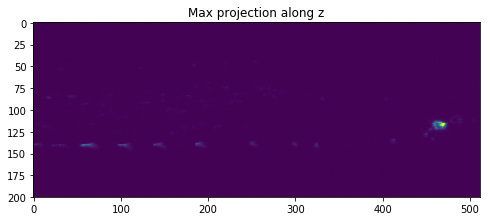

interactive(children=(IntSlider(value=0, description='currentSlice', max=187), Output()), _dom_classes=('widge…

In [15]:
experimentID = expIDs[expIDIndex]
parameter_test_cache = experimentID + '_test_cache.pkl'
batch_cache = experimentID + '_batch_cache.pkl'
imageCurrent, metadataCurrent, saveLocation = inspectTrial(experimentID)

##### Test parameter set

In [16]:
bottomSlice = 55
topSlice = 110

gaussianWidth = 3
particleZDiameter = 25
particleXYDiameter = 15
particleDiameter = (particleZDiameter,particleXYDiameter,particleXYDiameter)
brightnessPercentile = 75
minParticleMass = 100

trackingSeachRadius = 20

[Skipped the cell's code and loaded variables mitoCandidates from file '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir/SSN_095_001_test_cache.pkl'.]


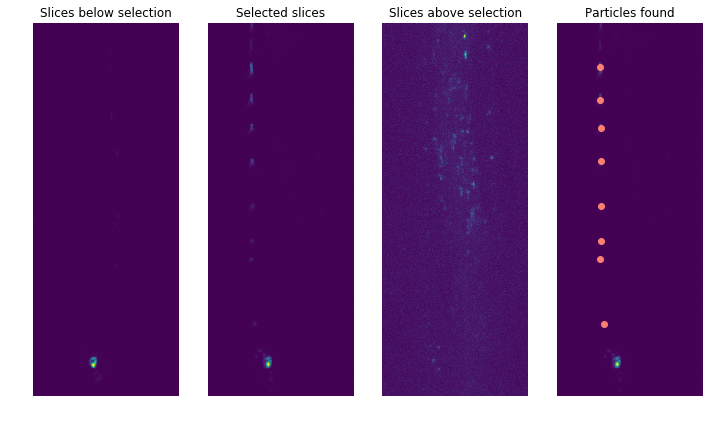

In [17]:
%%cache $parameter_test_cache mitoCandidates --cachedir /Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir 

mitoCandidates = test_particle_finding_parameters(imageCurrent)

##### Run batch with the parameters we chose

[Skipped the cell's code and loaded variables particleTrajectories from file '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir/SSN_095_001_batch_cache.pkl'.]
Frame 0: 14 features
Frame 1: 16 features
Frame 2: 21 features
Frame 3: 21 features
Frame 4: 22 features
Frame 1: 16 trajectories present.
Frame 2: 21 trajectories present.
Frame 3: 21 trajectories present.
Frame 4: 22 trajectories present.


/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


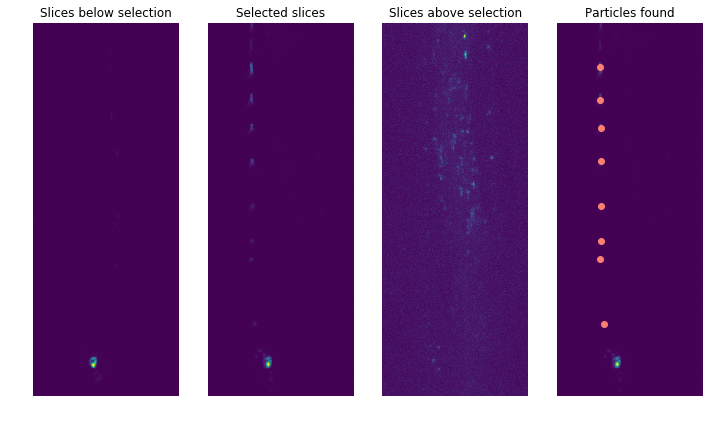

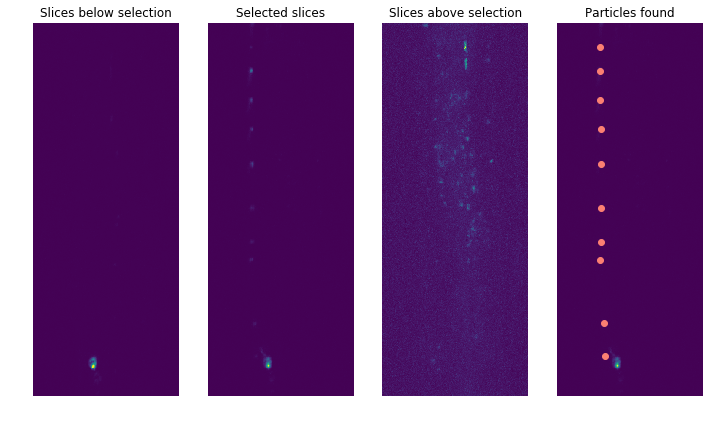

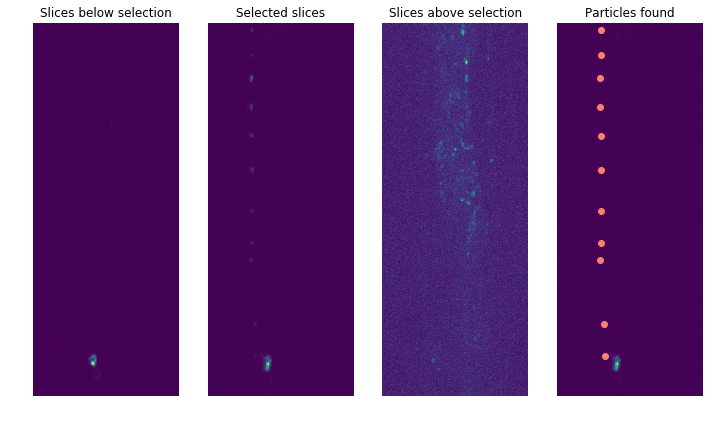

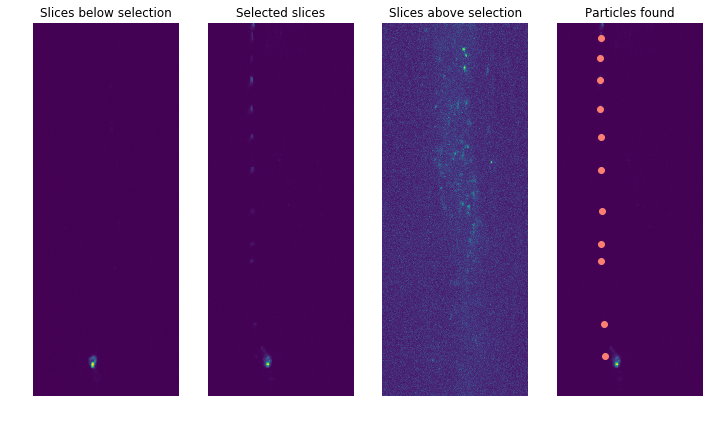

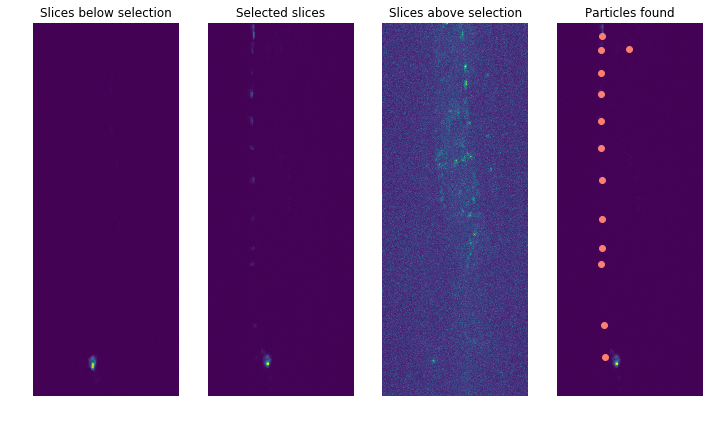

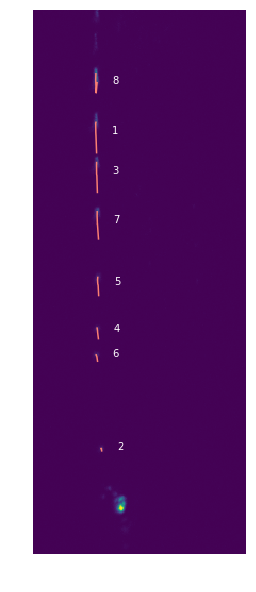

In [18]:
%%cache $batch_cache particleTrajectories --cachedir /Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir 

particleTrajectories = run_batch(imageCurrent);

In [19]:
finishThisFileTime = time.time()
print('Time to analyze this trial was ' + str(round(finishThisFileTime - startTime)) + ' seconds.')

Time to analyze this trial was 8 seconds.


### 2

In [20]:
startTime = time.time()
timePoint = 0
expIDIndex = 1

##### Take a look at the images

Notes from this experiment: Worm sat in trap for a few minutes while I was setting up. Took 5 stacks in a row. Worm moving quite a bit, so moving on to the next one.
Worm vulva is on the South side.


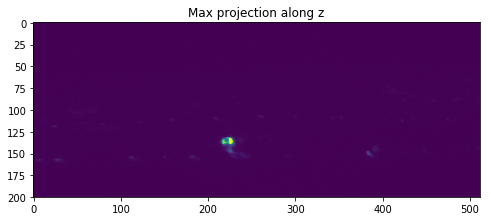

interactive(children=(IntSlider(value=0, description='currentSlice', max=194), Output()), _dom_classes=('widge…

In [21]:
experimentID = expIDs[expIDIndex]
parameter_test_cache = experimentID + '_test_cache.pkl'
batch_cache = experimentID + '_batch_cache.pkl'
imageCurrent, metadataCurrent, saveLocation = inspectTrial(experimentID)

##### Test parameter set

In [22]:
bottomSlice = 55
topSlice = 110

gaussianWidth = 3
particleZDiameter = 25
particleXYDiameter = 15
particleDiameter = (particleZDiameter,particleXYDiameter,particleXYDiameter)
brightnessPercentile = 75
minParticleMass = 80000

trackingSeachRadius = 50

[Skipped the cell's code and loaded variables mitoCandidates from file '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir/SSN_096_001_test_cache.pkl'.]


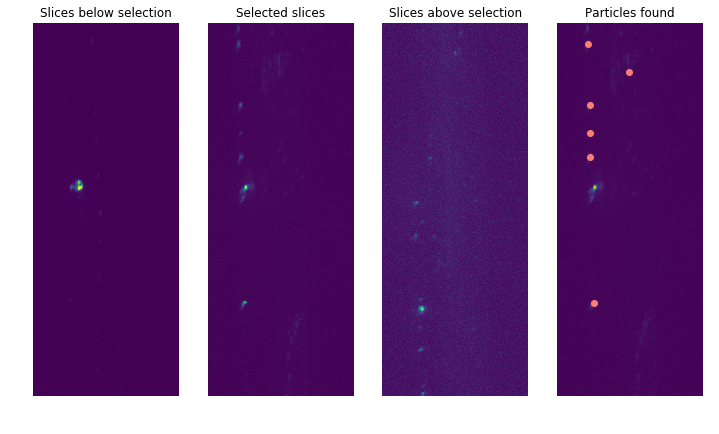

In [23]:
%%cache $parameter_test_cache mitoCandidates --cachedir /Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir

mitoCandidates = test_particle_finding_parameters(imageCurrent)

##### Run batch with the parameters we chose

[Skipped the cell's code and loaded variables particleTrajectories from file '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir/SSN_096_001_batch_cache.pkl'.]
Frame 0: 11 features
Frame 1: 16 features
Frame 2: 10 features
Frame 3: 14 features
Frame 4: 10 features
Frame 1: 16 trajectories present.
Frame 2: 10 trajectories present.
Frame 3: 14 trajectories present.
Frame 4: 10 trajectories present.


/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


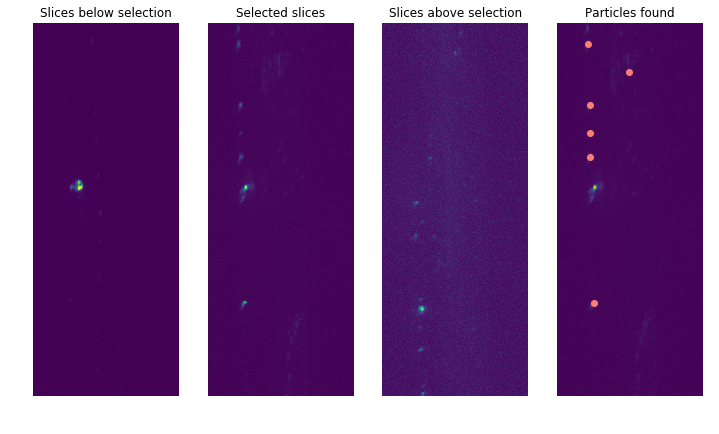

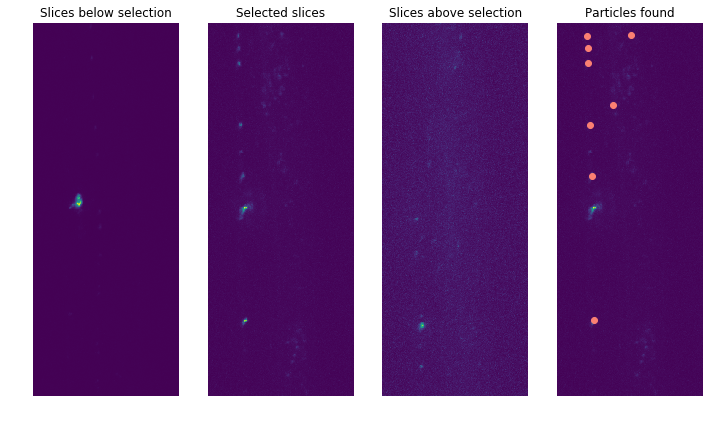

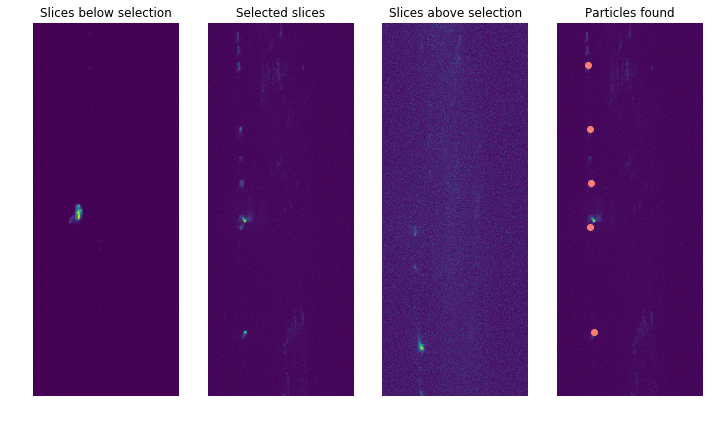

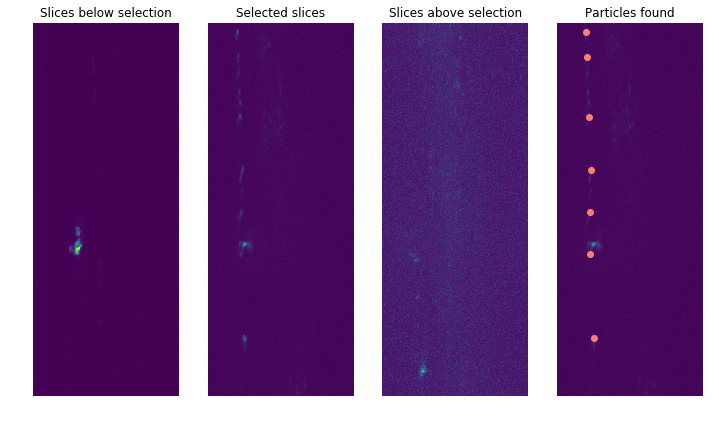

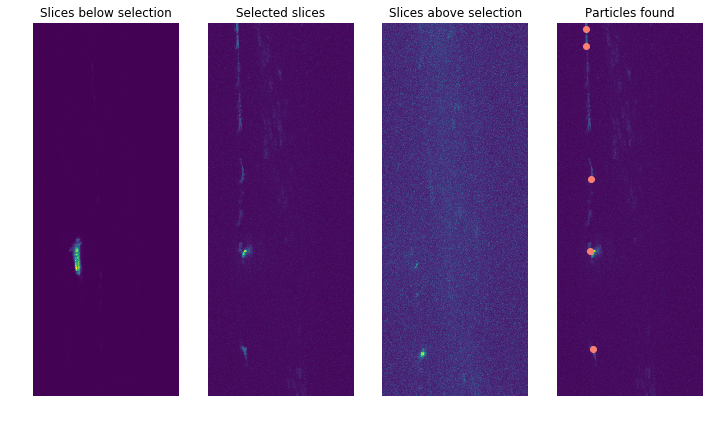

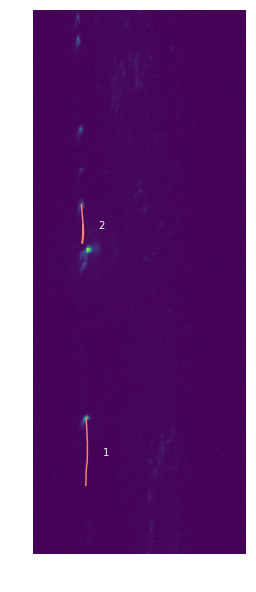

In [24]:
%%cache $batch_cache particleTrajectories --cachedir /Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir

particleTrajectories = run_batch(imageCurrent);

In [25]:
finishThisFileTime = time.time()
print('Time to analyze this trial was ' + str(round(finishThisFileTime - startTime)) + ' seconds.')

Time to analyze this trial was 8 seconds.


### 3

In [26]:
startTime = time.time()
timePoint = 0
expIDIndex = -1

##### Take a look at the images

Notes from this experiment: Pretty big for a worm with no eggs. Tried actuation on 2nd and 4th stacks, but valve was closed.
Worm vulva is on the North side.


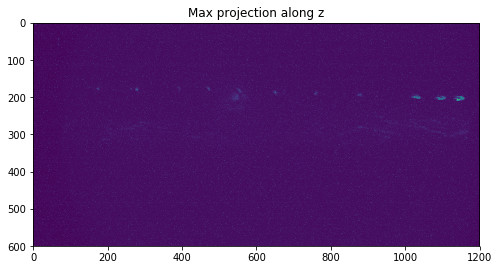

interactive(children=(IntSlider(value=0, description='currentSlice', max=79), Output()), _dom_classes=('widget…

In [27]:
experimentID = expIDs[expIDIndex]
parameter_test_cache = experimentID + '_test_cache.pkl'
batch_cache = experimentID + '_batch_cache.pkl'
imageCurrent, metadataCurrent, saveLocation = inspectTrial(experimentID)

##### Test parameter set

In [28]:
bottomSlice = 0
topSlice = 50

gaussianWidth = 3
particleZDiameter = 25
particleXYDiameter = 15
particleDiameter = (particleZDiameter,particleXYDiameter,particleXYDiameter)
brightnessPercentile = 75
minParticleMass = 2000

trackingSeachRadius = 50

[Skipped the cell's code and loaded variables mitoCandidates from file '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir/SSN_103_001_test_cache.pkl'.]


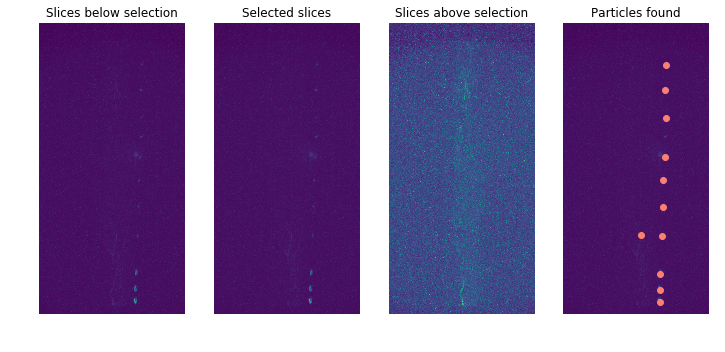

In [29]:
%%cache $parameter_test_cache mitoCandidates --cachedir /Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir

mitoCandidates = test_particle_finding_parameters(imageCurrent)

In [30]:
display(mitoCandidates)

z            y           x          mass    size_z    size_y  \
0             NaN          NaN         NaN           NaN       NaN       NaN   
1             NaN          NaN         NaN           NaN       NaN       NaN   
2             NaN          NaN         NaN           NaN       NaN       NaN   
3             NaN          NaN         NaN           NaN       NaN       NaN   
4             NaN          NaN         NaN           NaN       NaN       NaN   
5             NaN          NaN         NaN           NaN       NaN       NaN   
6             NaN          NaN         NaN           NaN       NaN       NaN   
7             NaN          NaN         NaN           NaN       NaN       NaN   
8             NaN          NaN         NaN           NaN       NaN       NaN   
9             NaN          NaN         NaN           NaN       NaN       NaN   
10            NaN          NaN         NaN           NaN       NaN       NaN   
1803    13.536172   391.925426  421.107178   2182.319153  6.173899  4.386262   
17257   15.066198   554.214848  416.046099   4094.724541  6.182270  4.924450   
27002   17.928495   650.028585  411.046979   4055.697666  6.044550  4.693685   
32810   18.686667   876.226292  317.656238   2271.346446  5.125306  5.478228   
39391   20.477365   174.774844  420.824275   3254.806006  6.986898  3.943423   
44411   21.039956   278.848654  418.405154   7036.607574  6.895623  4.154903   
55612   23.345107   758.078961  407.834051   4542.427404  6.967345  4.606478   
86844   30.440720   879.518914  404.848476   3347.727138  5.510786  5.169820   
92089   31.259949  1033.654623  397.959250   7703.073330  5.242334  5.517291   
97066   32.854724  1100.835321  396.393856   7739.976294  5.641811  5.306289   
116576  34.877447  1150.064402  396.803766  14211.092409  6.020257  5.092461   

          size_x  ecc     signal  raw_mass      ep_z      ep_y      ep_x  
0            NaN  NaN        NaN       NaN  0.239250  0.138683  0.138683  
1            NaN  NaN        NaN       NaN  0.121868  0.070642  0.070642  
2            NaN  NaN        NaN       NaN  0.164050  0.095093  0.095093  
3            NaN  NaN        NaN       NaN  0.245845  0.142507  0.142507  
4            NaN  NaN        NaN       NaN  0.212331  0.123080  0.123080  
5            NaN  NaN        NaN       NaN  0.098705  0.057215  0.057215  
6            NaN  NaN        NaN       NaN  0.144861  0.083970  0.083970  
7            NaN  NaN        NaN       NaN  0.203210  0.117792  0.117792  
8            NaN  NaN        NaN       NaN  0.096700  0.056053  0.056053  
9            NaN  NaN        NaN       NaN  0.095743  0.055498  0.055498  
10           NaN  NaN        NaN       NaN  0.054385  0.031525  0.031525  
1803    5.035917  NaN   3.716845  256242.0       NaN       NaN       NaN  
17257   5.091170  NaN   5.752261  265002.0       NaN       NaN       NaN  
27002   4.759243  NaN   7.345194  260411.0       NaN       NaN       NaN  
32810   4.215874  NaN   4.336319  255998.0       NaN       NaN       NaN  
39391   4.643280  NaN   5.840757  257395.0       NaN       NaN       NaN  
44411   4.554604  NaN  12.389484  269192.0       NaN       NaN       NaN  
55612   4.555784  NaN   7.345194  262168.0       NaN       NaN       NaN  
86844   4.767518  NaN   5.663764  257855.0       NaN       NaN       NaN  
92089   4.601935  NaN  12.654973  269649.0       NaN       NaN       NaN  
97066   4.911053  NaN  11.593017  269874.0       NaN       NaN       NaN  
116576  4.820357  NaN  22.566561  287157.0       NaN       NaN       NaN

##### Run batch with the parameters we chose

[Skipped the cell's code and loaded variables particleTrajectories from file '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir/SSN_103_001_batch_cache.pkl'.]
Frame 0: 22 features
Frame 1: 18 features
Frame 2: 18 features
Frame 3: 10 features
Frame 4: 16 features
Frame 1: 18 trajectories present.
Frame 2: 18 trajectories present.
Frame 3: 10 trajectories present.
Frame 4: 16 trajectories present.


/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


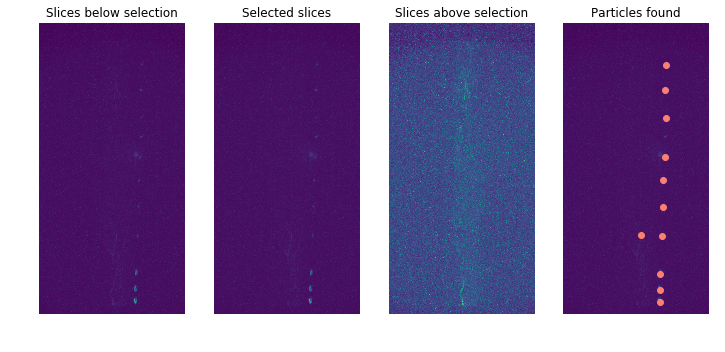

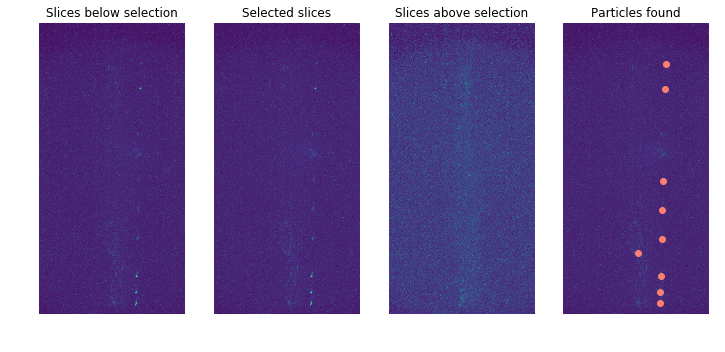

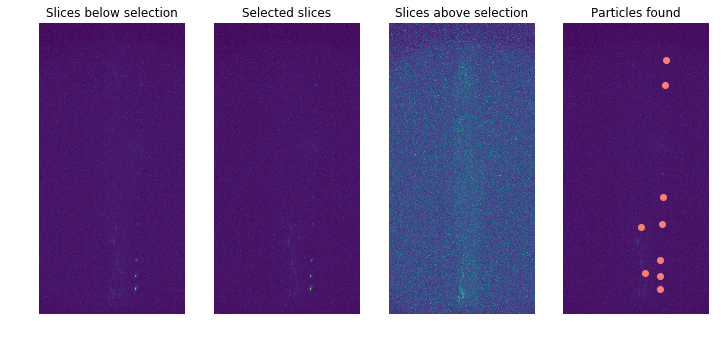

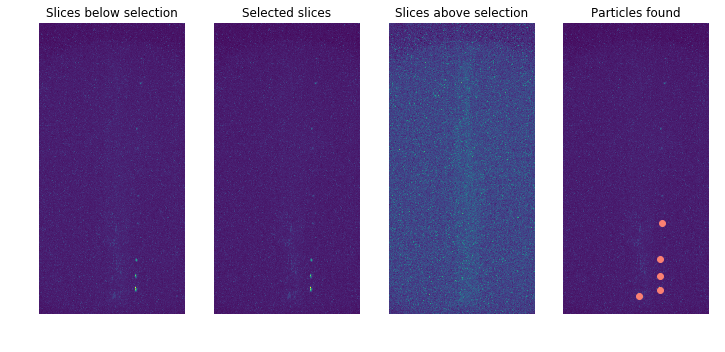

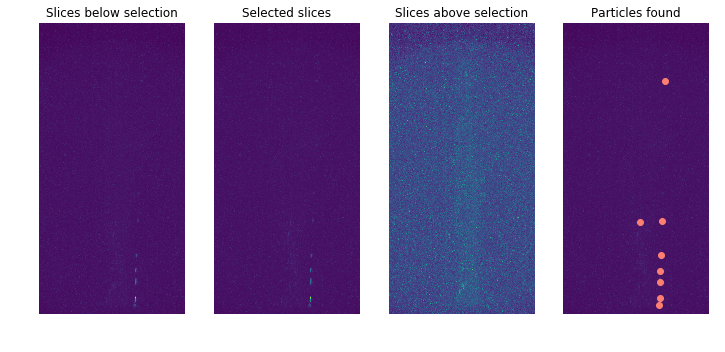

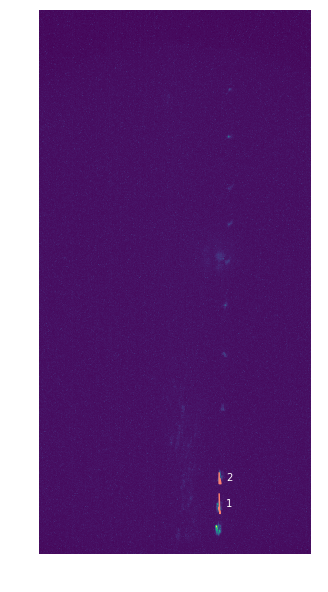

In [31]:
%%cache $batch_cache particleTrajectories --cachedir /Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/.ipycacheDir

particleTrajectories = run_batch(imageCurrent);

In [32]:
finishThisFileTime = time.time()
print('Time to analyze this trial was ' + str(round(finishThisFileTime - startTime)) + ' seconds.')

Time to analyze this trial was 26 seconds.
